In [1]:
DATA_FOLDER = '/media/HDD1/data/atari_v2/raw'

In [20]:
import numpy as np
from os import listdir
from os.path import join as pjoin
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 
from util import load_trajectories
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's load some screenshots to see that they are okay.

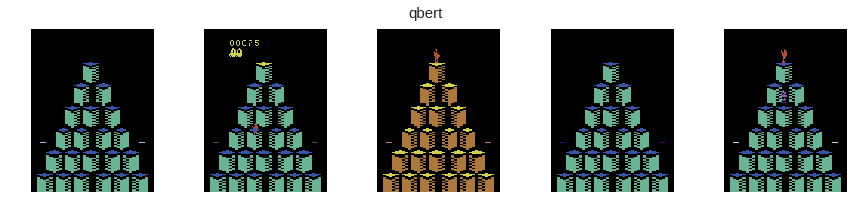

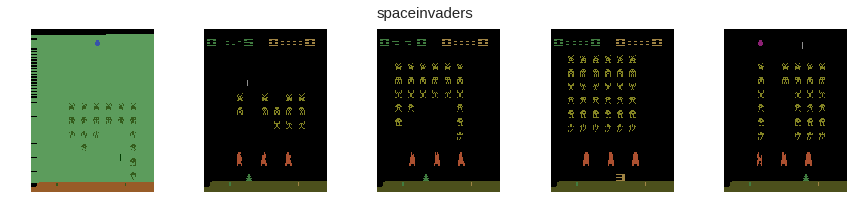

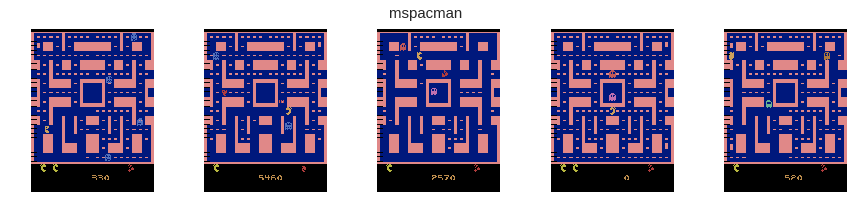

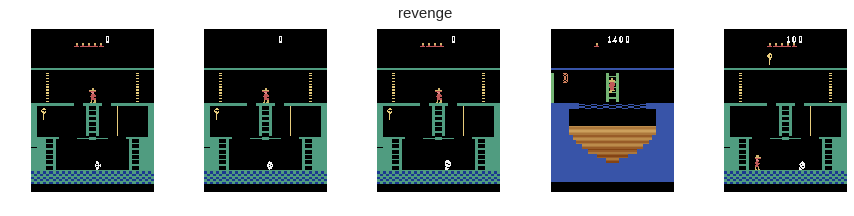

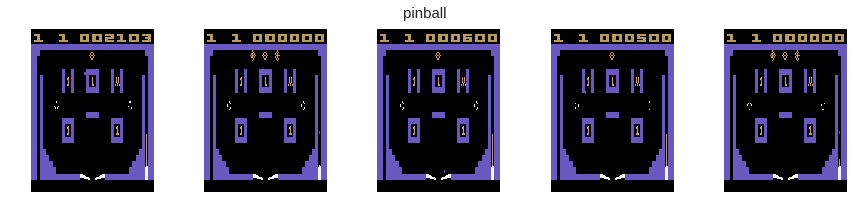

In [12]:
dirs = listdir(pjoin(DATA_FOLDER, 'screens'))
np.random.shuffle(dirs)
for i in range(5):
    fig, axes = plt.subplots(1,5, figsize=(15,3))
    fig.suptitle(dirs[i], fontsize=15)
    cg = pjoin(DATA_FOLDER, 'screens', dirs[i])
    for j in range(5):
        cf = pjoin(cg, np.random.choice(listdir(cg)))
        ci = cv2.imread(pjoin(cf, np.random.choice(listdir(cf))))
        axes[j].imshow(cv2.cvtColor(ci, cv2.COLOR_BGR2RGB))
        axes[j].axis('off')

In [21]:
trajectories = load_trajectories(pjoin(DATA_FOLDER, 'trajectories'))

In [22]:
def get_scores(trajectories, bottom_frame_limit=None, upper_frame_limit=None):
    scores = {}
    total_traj = 0
    for g in trajectories:
        scores[g] = []
        total_traj+=len(trajectories[g].keys())
        for t in trajectories[g]:
            for i in range(bottom_frame_limit if bottom_frame_limit else 0, upper_frame_limit if upper_frame_limit else len(trajectories[g][t])):
                scores[g].append(trajectories[g][t][i][2])
    return scores, total_traj

scores, total_traj = get_scores(trajectories)
print("Total trajectories: %d." % (total_traj))
print("Total frames:       %s." % "{:,}".format((sum([len(scores[g]) for g in scores]))))

Total trajectories: 7432.
Total frames:       22,365,791.


Since we know about the existance of *crazy scores* for the first several frames, let's find them on 'per game' basis. Assume that a person was not able to obtain scores for the first 10 frames of the game (1/6 of a second). Let's remove zeroes from the scores since we're okay with them for the first frames (the player hasn't just got any score yet. We can see, that some scores are really far from 0 that is super improbable for the beginning of the game. Moreover, some scores have a peak, that should be something strange.

### Early game score distribution

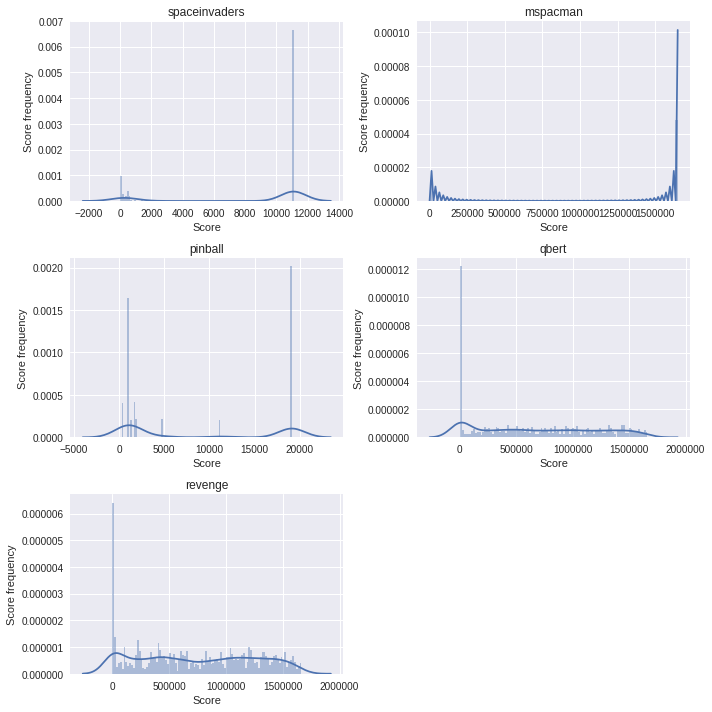

In [23]:
first_frame_scores, _ = get_scores(trajectories, upper_frame_limit=10)
f, axes = plt.subplots(3,2, figsize=(10,10))
for i,g in enumerate(first_frame_scores):
    cax = axes[i//2,i%2]
    cax.set_title(g)
    cax.set_xlabel('Score')
    cax.set_ylabel('Score frequency')
    sns.distplot(np.random.choice([el for el in first_frame_scores[g] if el > 0], 10000), bins = 100, ax=cax)
axes[2,1].axis('off');
plt.tight_layout()

In [24]:
def get_reward(bottom_frame_limit=None, upper_frame_limit=None):
    scores = {}
    total_traj = 0
    for g in trajectories:
        scores[g] = []
        total_traj+=len(trajectories[g].keys())
        for t in trajectories[g]:
            for i in range(bottom_frame_limit if bottom_frame_limit else 0, upper_frame_limit if upper_frame_limit else len(trajectories[g][t])):
                scores[g].append(trajectories[g][t][i][1])
    return scores

def crazy_check(game):
    res = []
    res.append(len(set([el for el in get_reward(5,10)[game] if el < 0])))
    res.append(len(set([el for el in get_reward(3,5)[game] if el < 0])))
    res.append(len(set([el for el in get_reward(2,3)[game] if el < 0])))
    res.append(len(set([el for el in get_reward(1,2)[game] if el < 0])))
    return res

During data exploration I found that at the first several frames there may be a huge negative reward. Looks like it happens because after the memory is initialised, we reset our huge score to 0, and the reward is negative. 

Let's find when the negative reward happens. The negative reward comes exactly in frame 2 for mspacman, for instance. Let's check for other games.

In [25]:
for g in trajectories:
    print(g)
    print(crazy_check(g))

spaceinvaders
[0, 0, 1, 1]
mspacman
[0, 0, 0, 80]
pinball
[0, 0, 0, 7]
qbert
[0, 0, 0, 858]
revenge
[0, 0, 0, 969]


## What's the conclusion?

### What we assume crazy

* the same score through all the game (like 1650000 for the whole trajectory in mspacman or 8100 in revenge)
* negative reward for the first frames

*We will fix this craziness in the notebook **data_exploration_correction** *. Stay tuned!